<a href="https://colab.research.google.com/github/maltevolle/PMML-Project/blob/michael/Workcopy_Project_PMML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [1]:
import numpy as np
from torch import nn
import torch
from torch import optim
import torchvision
from torchvision import models
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split



# Image Processing


In [3]:
train_transforms = transforms.Compose([transforms.Resize(140),
                                       transforms.CenterCrop(140),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,),(0.5,))])
test_transforms = transforms.Compose([transforms.Resize(140),
                                      transforms.CenterCrop(140),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5))])

# Define a basic transform that includes resizing and converting to tensor
raw_transform = transforms.Compose([
                                      transforms.Resize((240, 240)),  # Resize to a fixed size (e.g., 240x240)
                                      transforms.ToTensor()           # Convert to tensor
])


In [4]:
# Load the HuggingFace Dataset
from datasets import load_dataset
dataset = load_dataset("Rapidata/Animals-10", split="train")
dataset = dataset.shuffle(seed=42)  # Shuffle the dataset with a fixed seed

# Split into training, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

train_dataset = dataset.select(range(int(len(dataset) * train_size)))
val_dataset = dataset.select(range(int(len(dataset) * train_size), int(len(dataset) * (train_size + val_size))))
test_dataset = dataset.select(range(int(len(dataset) * (train_size + val_size)), len(dataset)))

# Define DataLoader using standard Hugging Face Dataset API
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Apply the transformations
train_set = CustomDataset(train_dataset, transform=train_transforms)
val_set = CustomDataset(val_dataset, transform=test_transforms)
test_set = CustomDataset(test_dataset, transform=test_transforms)

# Create data loaders
batch_size = 20
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23554 [00:00<?, ? examples/s]

# Visualisation

In [5]:
# Function for visualizing images
def visualize_images(dataset_loader, classes, title="Images"):
    """
    Visualize a batch of images from a DataLoader.

    Args:
    - dataset_loader (DataLoader): The DataLoader containing the images to visualize.
    - classes (list): List of class names for labels.
    - title (str): Title of the visualization plot.
    """
    images, labels = next(iter(dataset_loader))
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])
    plt.suptitle(title)
    plt.show()


def imshow(img):
    """
    Helper function to unnormalize and display an image.
    """
    img = img / 2 + 0.5  # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

Visualizing Before Applying Transforms:


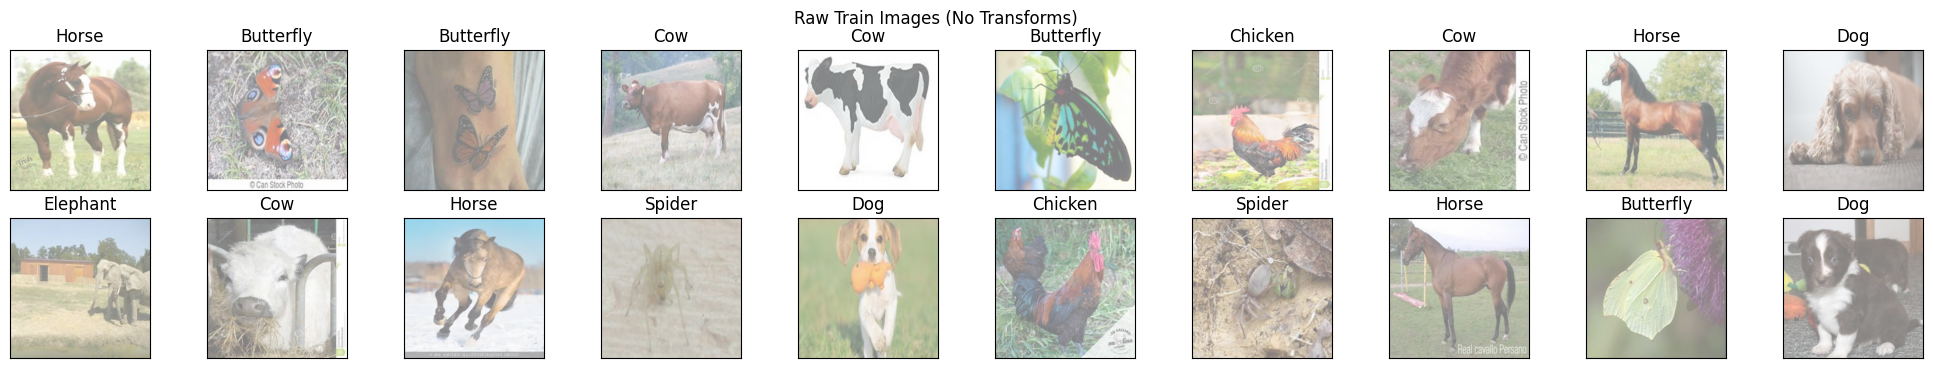

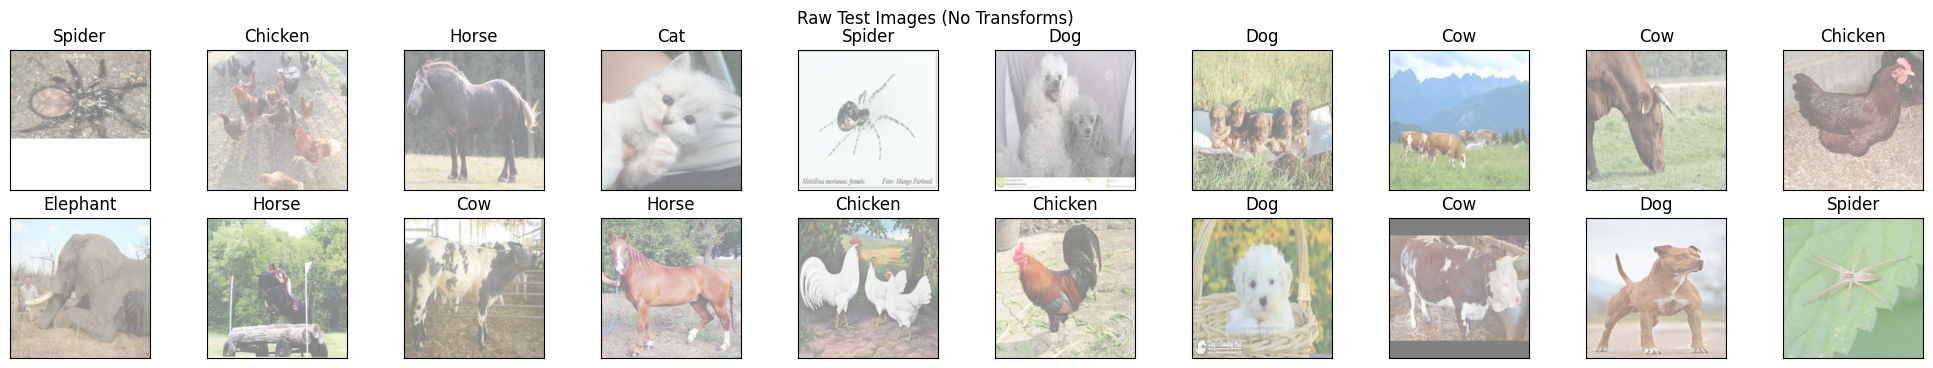

Visualizing After Applying Transforms:


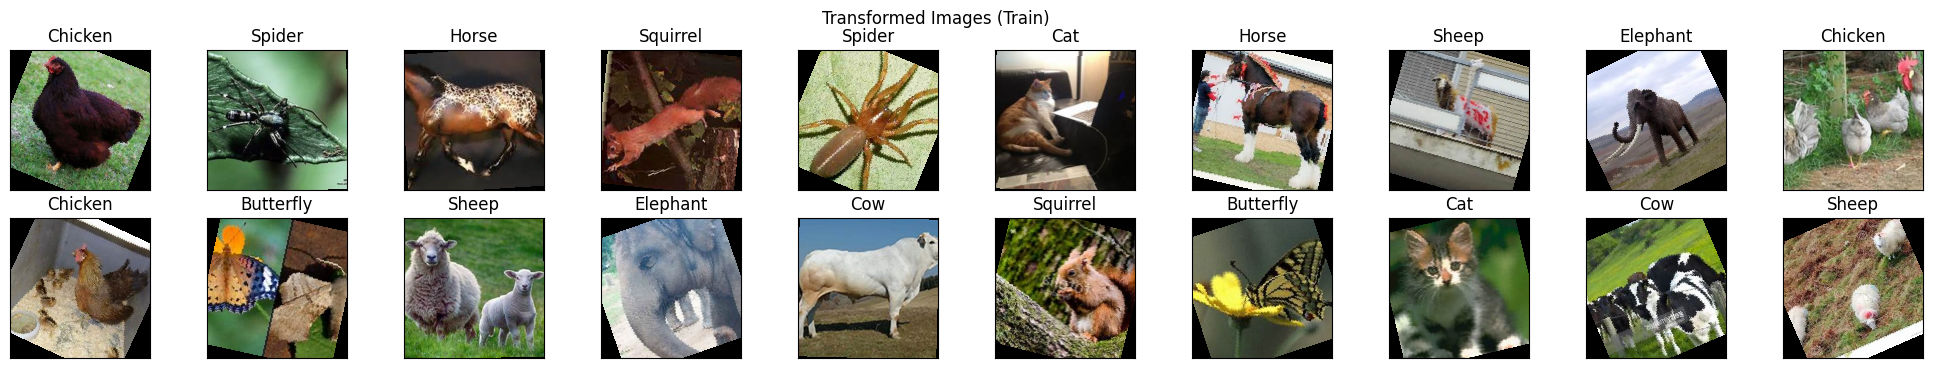

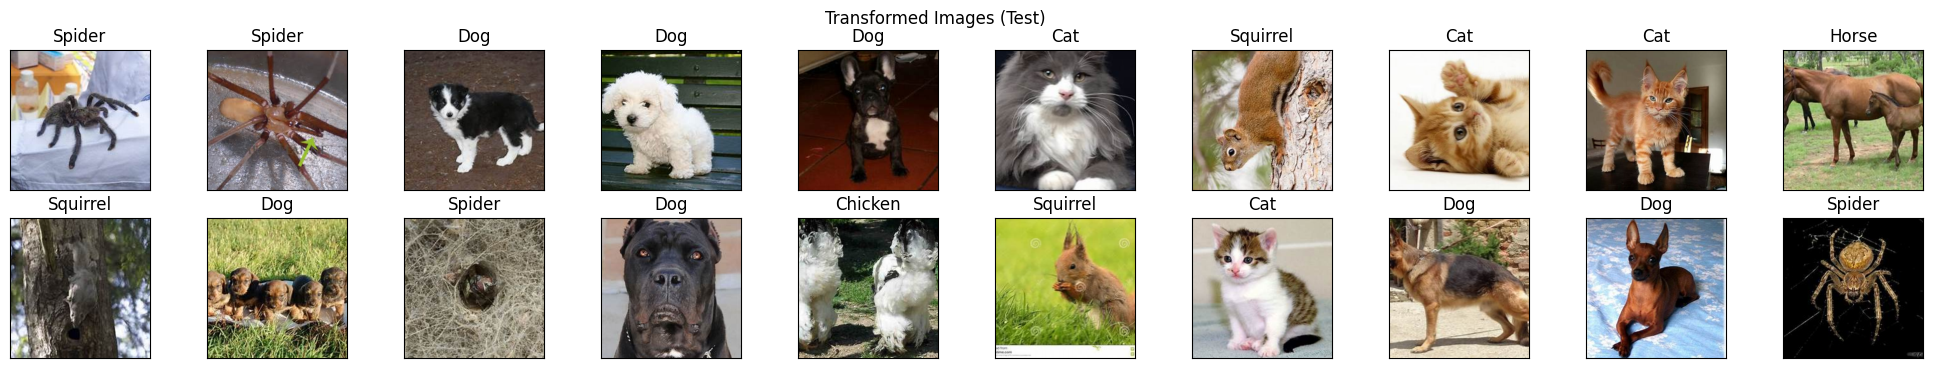

In [6]:
# Get class names from the dataset
classes = train_dataset.features['label'].names

#Data loaders for raw images
raw_train_loader = DataLoader(CustomDataset(train_dataset, transform=raw_transform), batch_size=batch_size, shuffle=True)
raw_test_loader = DataLoader(CustomDataset(test_dataset, transform=raw_transform), batch_size=batch_size, shuffle=True)

# Visualize before applying transforms
print("Visualizing Before Applying Transforms:")
visualize_images(raw_train_loader, classes, title="Raw Train Images (No Transforms)")
visualize_images(raw_test_loader, classes, title="Raw Test Images (No Transforms)")

# Visualize after applying transforms
print("Visualizing After Applying Transforms:")
visualize_images(train_loader, classes, title="Transformed Images (Train)")
visualize_images(test_loader, classes, title="Transformed Images (Test)")

# Basic Stats

In [7]:
# Basic Stats
print(f"Classes: {classes}")

Classes: ['Butterfly', 'Cat', 'Chicken', 'Cow', 'Dog', 'Elephant', 'Horse', 'Sheep', 'Spider', 'Squirrel']


# Building the Classifier

In [8]:
res_18_model = models.resnet18(pretrained=True)
res_18_model.fc= nn.Linear(512, 10)

model=res_18_model
if(torch.cuda.is_available()==True):
    model=res_18_model.cuda()

optimiser=optim.SGD(model.parameters(),lr=0.03)
loss=nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.9MB/s]


# Training Loop

In [9]:
!pip install wandb -qU

# Log in to your W&B account
import wandb
import random
import math


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 62.9 MB/s eta 0:00:00


In [10]:
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="PMML",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.03,
    "architecture": "ResNet",
    "dataset": "Animal10",
    "epochs": 1,
    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: michael-girsh (michael-girsh-ruhr-university-bochum). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [11]:
from tqdm import tqdm  # For progress bar

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=2, gamma=0.1)  # Reduce LR every 2 epochs

nb_epochs = 1
for epoch in range(nb_epochs):
    # Training Phase
    model.train()
    train_losses = []
    train_accuracies = []

    print(f"Epoch {epoch + 1}/{nb_epochs}")
    for x, y in tqdm(train_loader, desc="Training", leave=False):
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        # Forward pass
        outputs = model(x)

        # Compute the loss
        J = loss(outputs, y)

        # Zero the gradients
        optimiser.zero_grad()

        # Backward pass
        J.backward()

        # Optimizer step
        optimiser.step()

        # Record loss
        train_losses.append(J.item())

        # Compute accuracy
        _, predictions = torch.max(outputs, dim=1)
        acc = (predictions == y).float().mean()  # Mean accuracy for the batch
        train_accuracies.append(acc.item())

        # Log batch-wise metrics to W&B
        wandb.log({
            "Train Batch Loss": J.item(),
            "Train Batch Accuracy": acc.item(),
            "Epoch": epoch + 1,
            "Learning Rate": scheduler.get_last_lr()[0],
        })

    # Compute epoch training metrics
    avg_train_loss = np.mean(train_losses)
    avg_train_accuracy = np.mean(train_accuracies)

    # Validation Phase
    model.eval()
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc="Validating", leave=False):
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()

            # Forward pass
            outputs = model(x)

            # Compute the loss
            J = loss(outputs, y)
            val_losses.append(J.item())

            # Compute accuracy
            _, predictions = torch.max(outputs, dim=1)
            acc = (predictions == y).float().mean()
            val_accuracies.append(acc.item())

    # Compute epoch validation metrics
    avg_val_loss = np.mean(val_losses)
    avg_val_accuracy = np.mean(val_accuracies)

    # Step the learning rate scheduler
    scheduler.step()

    # Log metrics to W&B
    wandb.log({
        "Epoch": epoch + 1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": avg_train_accuracy,
        "Val Loss": avg_val_loss,
        "Val Accuracy": avg_val_accuracy,
        "Learning Rate": scheduler.get_last_lr()[0],  # Log current learning rate
    })

    # Print epoch summary
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")


# Save the trained model
model_save_path = "resnet18_animal10_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/1


Train Loss: 0.4573, Train Accuracy: 0.8519
Val Loss: 0.2169, Val Accuracy: 0.9260
Model saved to resnet18_animal10_model.pth


# Adversial Attacks

In [13]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requ

In [14]:
import torchattacks  # For adversarial attacks

In [15]:
# Load the saved model
best_model = models.resnet18(pretrained=False)  # Same architecture
best_model.fc = nn.Linear(512, 10)  # Adjust the final layer
best_model.load_state_dict(torch.load(model_save_path))
best_model.eval()  # Set to evaluation mode

if torch.cuda.is_available():
    best_model = best_model.cuda()

print("Model loaded and ready for adversarial attacks.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded and ready for adversarial attacks.


<ipython-input-15-de59e1d5ac5b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_save_path))


### Targeted Misclassification

#### Own Target Model

In [20]:
# Adversarial Generator
class AdversarialGenerator(nn.Module):
    def __init__(self, input_size):
        super(AdversarialGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.Tanh(),
        )

    def forward(self, x):
        perturbation = self.fc(x.view(x.size(0), -1))
        return perturbation.view(x.size())


# Initialize the generator
input_size = 3 * 140 * 140
generator = AdversarialGenerator(input_size)
if torch.cuda.is_available():
    generator = generator.cuda()

adv_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
target_class = 3  # Example target class

# Train Adversarial Generator
print("Training Adversarial Generator...")
for epoch in range(5):  # Train for 5 epochs
    generator.train()
    epoch_loss = 0
    batch_count = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        # Generate adversarial examples
        perturbations = generator(x)
        adv_examples = torch.clamp(x + perturbations, 0, 1)

        # Compute adversarial loss
        outputs = best_model(adv_examples)
        target_labels = torch.full_like(y, target_class).to(y.device)
        adv_loss = nn.CrossEntropyLoss()(outputs, target_labels)

        # Update generator
        adv_optimizer.zero_grad()
        adv_loss.backward()
        adv_optimizer.step()

        # Accumulate loss
        epoch_loss += adv_loss.item()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    print(f"Epoch {epoch + 1} completed. Average Adversarial Loss: {avg_loss:.4f}")

# Save the trained generator
generator_save_path = "adversarial_generator.pth"
torch.save(generator.state_dict(), generator_save_path)
print(f"Adversarial Generator saved to {generator_save_path}")

# Evaluate the Adversarial Generator
print("Evaluating Adversarial Generator...")
generator.eval()
adv_correct, total = 0, 0
for x, y in tqdm(test_loader, desc="Evaluating", leave=False):
    if torch.cuda.is_available():
        x, y = x.cuda(), y.cuda()

    # Generate adversarial examples
    perturbations = generator(x)
    adv_examples = torch.clamp(x + perturbations, 0, 1)
    outputs = best_model(adv_examples)
    _, preds = torch.max(outputs, 1)

    total += y.size(0)
    adv_correct += (preds == target_class).sum().item()

adv_accuracy = adv_correct / total
print(f"Adversarial Generator Success Rate (misclassified as {target_class}): {adv_accuracy:.4f}")


Training Adversarial Generator...


KeyboardInterrupt: 

#### FGSM

In [16]:
from torchattacks import FGSM

In [21]:
t_atk_fgsm = FGSM(best_model, eps=16/255)
t_atk_fgsm.set_mode_targeted_by_label(quiet=True)
print(t_atk_fgsm)

FGSM(model_name=ResNet, device=cpu, attack_mode=targeted(label), targeted=True, normalization_used=False, eps=0.06274509803921569)


In [22]:
target_correct, total = 0, 0
for images, labels in test_loader:
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    # Generate a tensor of target labels for the entire batch
    target_label_idx = train_dataset.features['label'].names.index('Dog')
    target_labels = torch.full_like(labels, target_label_idx)  # Tensor with target_label_idx repeated

    # Generate adversarial examples
    adv_images = t_atk_fgsm(images, target_labels)


    # Evaluate the model on adversarial examples
    outputs = model(adv_images)
    _, preds = torch.max(outputs, dim=1)
    probs = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities

    # Log real and adversarial predictions
    for i in range(images.size(0)):
        real_label_idx = labels[i].item()
        adv_label_idx = preds[i].item()

        real_label = train_dataset.features['label'].names[real_label_idx]
        adv_label = train_dataset.features['label'].names[adv_label_idx]

        # Calculate the accuracy (confidence score)
        real_accuracy = probs[i][real_label_idx].item()
        adv_accuracy = probs[i][adv_label_idx].item()

        # Print the labels and accuracies
        print(f"Original prediction: ('{real_label}', {real_label_idx}) - Accuracy: {real_accuracy:.4f}")
        print(f"Adversarial prediction: ('{adv_label}', {adv_label_idx}) - Accuracy: {adv_accuracy:.4f}")

    # Count successful targeted attacks
    target_correct += (preds == target_label_idx).sum().item()
    total += labels.size(0)

print(f"FGSM Targeted Attack Success Rate: {target_correct / total:.4f}")

Original prediction: ('Spider', 8) - Accuracy: 0.0001
Adversarial prediction: ('Dog', 4) - Accuracy: 0.9672
Original prediction: ('Spider', 8) - Accuracy: 0.9599
Adversarial prediction: ('Spider', 8) - Accuracy: 0.9599
Original prediction: ('Dog', 4) - Accuracy: 0.2035
Adversarial prediction: ('Spider', 8) - Accuracy: 0.4085
Original prediction: ('Dog', 4) - Accuracy: 0.9998
Adversarial prediction: ('Dog', 4) - Accuracy: 0.9998
Original prediction: ('Dog', 4) - Accuracy: 0.0285
Adversarial prediction: ('Spider', 8) - Accuracy: 0.7539
Original prediction: ('Cat', 1) - Accuracy: 0.0100
Adversarial prediction: ('Dog', 4) - Accuracy: 0.9460
Original prediction: ('Squirrel', 9) - Accuracy: 0.8780
Adversarial prediction: ('Squirrel', 9) - Accuracy: 0.8780
Original prediction: ('Cat', 1) - Accuracy: 0.0288
Adversarial prediction: ('Dog', 4) - Accuracy: 0.4398
Original prediction: ('Cat', 1) - Accuracy: 0.0842
Adversarial prediction: ('Spider', 8) - Accuracy: 0.3532
Original prediction: ('Hors

KeyboardInterrupt: 

### Untargeted Misclassification

#### FGSM

In [ ]:
from torchattacks import FGSM

In [ ]:
u_atk_fgsm = FGSM(best_model, eps=16/255)
u_atk_fgsm.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print(u_atk_fgsm)

In [ ]:
# Untargeted attack evaluation
untargeted_correct, total = 0, 0
for images, labels in test_loader:
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()

    # Generate adversarial examples
    adv_images = u_atk_fgsm(images, labels)

    # Evaluate the model on adversarial examples
    outputs = model(adv_images)
    _, preds = torch.max(outputs, dim=1)

    # Log real and adversarial predictions
    for i in range(images.size(0)):
        real_label_idx = labels[i].item()
        adv_label_idx = preds[i].item()

        real_label = dataset.classes[real_label_idx]
        adv_label = dataset.classes[adv_label_idx]

        # Calculate the accuracy (confidence score)
        real_accuracy = probs[i][real_label_idx].item()
        adv_accuracy = probs[i][adv_label_idx].item()

        # Print the labels and accuracies
        print(f"Original prediction: ('{real_label}', {real_label_idx}) - Accuracy: {real_accuracy:.4f}")
        print(f"Adversarial prediction: ('{adv_label}', {adv_label_idx}) - Accuracy: {adv_accuracy:.4f}")

    # Count successful untargeted misclassifications
    total += labels.size(0)
    untargeted_correct += (preds != labels).sum().item()

print(f"FGSM Untargeted Attack Success Rate: {untargeted_correct / total:.4f}")
